## 1. **安装配置**
- 关于：
    - systemq：定义设备驱动和量子门
    - waveforms(qlisp)：将线路编译为波形指令
    - quarkstudio：设备控制和网络通信，执行编译生成的指令
- 安装：见[installation](../../#installation)。正确安装情况下，相关依赖都会自动装好。
    - 安装前：若无把握，**务必**删除干净电脑上**所有多余的Python或Conda**！！！
    - 安装后：确保**环境变量**被正确设置，否则提示命令找不到！！！

## 2. **设备调试**

- 如需编写驱动（可参考dev中其他设备的实现）：

    - 设备驱动必须继承自BaseDriver(`from quark.driver.common import BaseDriver`)
    - 所有驱动必须实现`open`/`close`/`write`/`read`方法


- 测试并确保设备驱动***完全无误***：
    ```python
    # 根据设备类型导入设备驱动，如网分
    from systemq.dev import NetworkAnalyzer

    # 根据设备地址实例化设备
    dev = NetworkAnalyzer.Driver('192.168.1.42')
    # 打开设备
    dev.open()

    # 设备写操作，通过setValue（实际调用`write`方法），可操作属性见驱动文件定义的quants列表
    dev.setValue('Power', -10)
    # 设备读操作，通过getValue（实际调用`read`方法），可操作属性见驱动文件定义的quants列表
    dev.getVaule('Power')
    ```
- > 如在实验过程中发现设备不正常工作，回到此处按此方法进行查验！！！

## 3. **实验详解**

- 按要求启动[**QuarkServer**](../../quark/server/)
    > 后以**server**代指**QuarkServer**，以**cfg**代指**QuarkServer**中的配置表（如示例中的[checkpoint.json](../checkpoint.json)）
- 以s21为例，更多范例见[**Experiment**](../demo/)

### **imports**
- **Recipe**: 记录任务信息，生成任务描述
- **s**: 与server进行通信交互的工具
    - 更新参数：`s.update('gate.Measure.Q0.params.frequency', 5.321e9)`
    - 查询参数：`s.query('gate.Measure.Q0.params.frequency')`
    - 写设备：`s.write('ZW_AD3.CH1.Offset', 0.2)`
    - 读设备：`s.read('ZW_AD3.CH1.Offset')`
- **submit**: 向server提交Recipe生成的任务

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from quark.app import Recipe, s, submit

In [ ]:
# 每次重启server都需要重新login，用户名与注册时保持一致
s.login('baqis')

# 如果login提示错误，则执行注册操作：signup
# 用户名任意(此处为baqis)，用于login
# 执行前需将cfg(如checkpoint.json)复制到： ~/Desktop/home/cfg(如目录不存在可自行创建)
# signup完毕后重新login即可
# s.signup('baqis','checkpoint')

2025-03-09 13:12:57.821 | INFO     | quark.app:login:124 - LOGINED[baqis], Checkpoint[2025-03-09 13:06:32 Sun] loaded from: C:\Users\NUC\Desktop\home\cfg\checkpoint.json


### **open device**
- `s.start()`根据设备连接类型不同打开或连接设备（可参考**quark server**启动时显示的信息）
    - 如果type=[driver](../../quark/server#what-is-dev)
        - 根据**name**从`etc.driver.path`指定路径导入Driver
        - 传入**addr**实例化Driver
        - 执行**open()**
        - > 设备上开启remote执行同样操作
    - 如果type=[remote](../../quark/remote)
        - ```connect(‘alias’, host, port) # 三个参数需和设备上配置完全一致```
        - 没有open()

- 即将dev中设备按如下方式打开
    ```bash
    for alias, info in dev.items():
        if type == 'driver':
            from systemq.dev import info['name'] as device
            d = device.Driver(info['addr'])
            d.open()
        elif type == 'remote':
            d = connect(‘alias’, host, port)
    ```
- 打开设备，在此之前，任务不可执行！

In [50]:
s.start()

'QuarkServer started!'

### **example: s21**
- 线路函数：生成qlisp，最后一个参数固定为ctx。在当前环境下，可令**ctx=s**。
    - 线路函数中尽量不引入额外参数，cfg中所有参数均可在外部临时修改，如示例中的***default_type***！
- 参数定义：rcp接受任意定义的参数，其中**list**或**np.array**被视为扫描变量。
    - cfg中所有参数均可扫描，只要将其按下述方式指定为**list**或**np.array**变量即可，如示例中的***frequency***。
    - qubits：线路参数之一，必须为**tuple**，若为**list**则会被视为变量！
- cfg配置（根据实际情况修改）：
    - 指定待测比特：`s.update('M1.qubits,['Q0','Q4','Q9'])`
    - 指定读取波形输出通道：`s.update('M1.channel.DDS,'ZW_AD3.CH1')`
    - 指定读取数据采集通道：`s.update('M1.channel.ADC,'ZW_AD3.CH13')`

In [41]:
def S21(qubits: list[str], ctx=None) -> list:
    cc = [(('Measure', i, ), q) for i, q in enumerate(qubits)]
    return cc


rcp = Recipe('s21', signal='iq_avg')
rcp.circuit = S21

qubits = tuple(['Q0', 'Q4', 'Q9'])
rcp['qubits'] = qubits
rcp['freq'] = np.linspace(-5, 5, 101) * 1e6

for q in qubits:
    rcp[f'gate.Measure.{q}.params.frequency'] = rcp['freq'] + \
        s.query(f'gate.Measure.{q}.params.frequency')
    rcp[f'gate.Measure.{q}.default_type'] = 'default'

# preview: 实时波形, 需要打开`quark canvas`
# plot: 实时数据(1d或2d)，需要打开`quark viewer`
s21 = submit(rcp.export(), preview=['M1'], plot=False)
s21.bar(interval=1)  # 获取数据的周期，默认为2s

baiqs:/s21   0%|          |0/101 [00:00<?, ?it/s, MainThread]

#### log information
- <font size="2">日志形如：📥[baqis, 0] 📤[2503072329410017622, 0] 🕓[100%(  1/  2)  0.000/ 0.436]<0.003, 0.003, 0.000> 💻(866.34, 3385.867)</font>
- <font size="2">对应含义：📥[用户名, 剩余任务数] 📤[任务id, 任务优先级] 🕓[进度(步数/总步数) 剩余时间/已用时间]<波形采样, **设备执行**, 数据处理> 💻(server占用内存, **系统剩余内存**)</font>
    > - 任务执行时间，一般情况下主要决定于**设备执行**时间！
    > - **系统剩余内存**如果过低，可能会导致电脑死机！

#### error report
- 如果任务出错非正常结束，可由`report`获取错误信息！

In [ ]:
s21.report()

#### cancel task
- 终止任务，取消后续的编译和执行流程

In [ ]:
s21.cancel()

#### circuit in qlisp
- 用于检查生成的线路是否正确，应和在此处直接调用线路函数结果一致！

In [11]:
cirq = s21.circuit(0)
cirq

[(('Measure', 0), 'Q0'), (('Measure', 1), 'Q4'), (('Measure', 2), 'Q8')]

#### commands sent to device
- cmds由编译生成，包含全部指令
- cmds由三部分构成，依次顺序执行，分别为
    - cmds['main']: 写波形（驱动、偏置、读取等所有波形，可由`preview`函数看波形）、设置AD(如Shots、解调系数等)。
    - cmds['trig']: 待cmds['main']中命令全部就绪，触发设备开始发**trigger**。***trigger数量务必与AD中的Shots设置一致！！！***
    - cmds['READ']: 从设备将数据读回。如果没有数据返回或TIMEOUT，***第一时间检查触发设置***！！！
- 若对下发到设备的指令存疑，可逐一排查cmds或单独执行cmds中命令以确定问题所在！

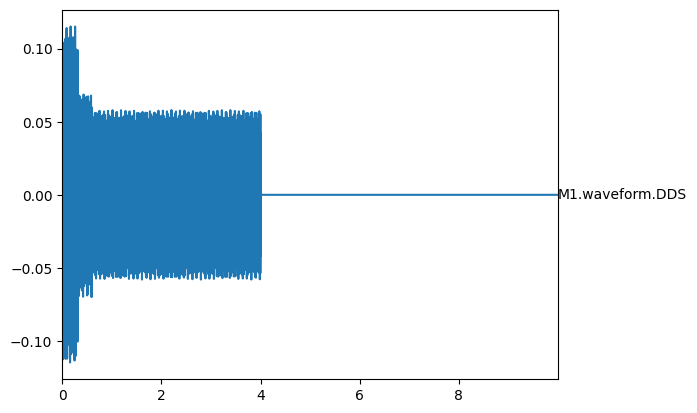

In [ ]:
from quark.app import preview

cmds = s21.step(0)
wfv = preview(cmds['main'], start=0, end=10e-6, srate=5e9, keys=['M1'])

#### result
- 结果可由`s21.result()`获取
- 也可以由get_data_by_rid获取
- 任务对应的cfg可由get_config_by_rid获取

In [28]:
from quark.app import get_data_by_rid, get_config_by_rid
rs = get_data_by_rid(s21.rid)
cfg = get_config_by_rid(s21.rid)

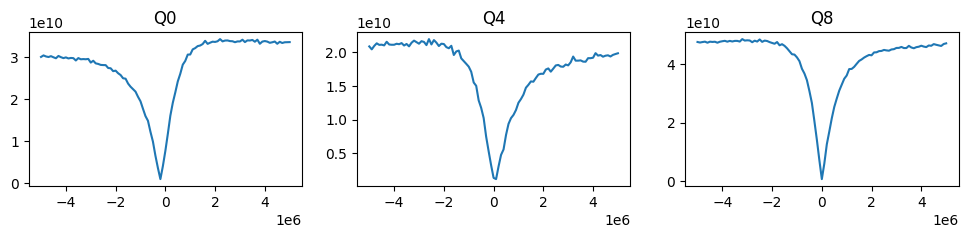

In [16]:
rs = s21.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['freq']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

## 4. **常见问题**
***遇到问题先看错误信息！遇到问题先看错误信息！遇到问题先看错误信息！***
1. 设备没有正常开启？
- 检查`etc.driver.path`是否正确，一般为`systemq/dev`或`dev`！
- 设备`type`为`remote`时，检查设备名字、`host`和`port`是否和设备的ip和端口匹配！

2. 线路编译错误？
- 检查线路编写是否有误！
- 检查`lib.gates.__init__`中导入的门模块是否正确，或cfg表中填写的参数是否匹配！

3. 实验没有数据或采集设备显示超时？
- 检查触发设备是否输出或`shots`设置和采集设备设置是否一致！

4. 波形下发错误？
- 检查设备上的numpy（**大**版本同为1.x.x或2.x.x）和waveforms版本和测量电脑是否一致！